# Project 5DEEP (Deep Learning) 
### Hugo Huygens - Matteo Gora

## Sujet: 

Vous devez télécharger et utiliser les jeux de données suivant : train et test (source : Kaggle).

Les données sont des images représentant les lettres de l'alphabet en langue des signes. Les classes indexées de 0 à 25 représentent les lettres de A à Z. À noter qu'il n'y a pas de données pour les lettres J et Z (car on ne les représente pas par des signes statiques mais par des mouvements).

Vous devrez développer "from scratch" vos propres réseaux de neurones pour résoudre ce problème de classification. Utiliser un modèle pré-entrainé n'est autorisé que dans la question correspondante.

Votre rendu se fera sous la forme d'un archive au format .zip contenant un notebook Jupyter (code source), son export au format PDF (ou HTML) ainsi qu'une sauvegarde de votre modèle final. Tout projet ne comportant pas ces trois éléments sera ajourné sans contestation possible.

Toutes les étapes de votre projet devront être commentées et justifiées. Tous les résultats devront être interprétés. La qualité de la rédaction (style, grammaire et orthographe) sera prise en compte. Un rendu professionnel est attendu.

L'usage de Python et de la librairie Tensorflow est obligatoire.

Charger les données et les transformer en images de 28 x 28 pixels.

Ce dataset est-il équilibré ? Est-il nécessaire de rééquilibrer les données ? Le faire si besoin est.

Construire un réseau de neurones convolutif pour résoudre ce problème de classification. Il devra contenir au minimum les éléments suivants : couches de convolution, couche de "pooling", "dropout", couches cachées complètement connectées. Vous êtes libres d'ajouter d'autres éléments.

Entraîner le modèle construit à la question précédente et mesurer sa performance.

Faire une recherche de meilleurs hyperparamètres avec la fonction "GridSearchCV“.

Utiliser une technique d'augmentation d'images. Les résultats de vos modèles s'en trouvent-ils améliorés ? Était-ce prévisible ?

Sauvegarder votre meilleur modèle.

Utiliser votre meilleur modèle avec des photos prises pour l'occasion où vous représenterez différents signes.

Choisir un des modèles pré-entrainés disponible avec Keras. Le charger et le personnaliser avec des couches de convolution et complètement connectées. L'entraîner et mesurer sa performance. La comparer avec celles de votre meilleur modèle.

### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras import layers, models
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.regularizers import l2




### Importation des datasets

In [2]:
train_data = pd.read_csv('./datasets/sign_mnist_train.csv')
test_data = pd.read_csv('./datasets/sign_mnist_test.csv')

### Transformation des images en 28 x 28 pixels.

Ici on affiche un échantillon de 25 images car plus pourrait être beaucoup trop lourd 

### Séparation des labels et des caractéristiques
Ici, nous séparons les données en deux ensembles : les caractéristiques (les pixels des images) et les labels (les classes cibles).
Le label correspond à la lettre de l'alphabet en langue des signes, et chaque image est représentée par 784 pixels (28x28).
Nous utilisons la méthode drop() pour enlever la colonne 'label' des données d'entraînement et de test, 
car cette colonne ne contient pas de pixels mais les classes cibles.

In [3]:
X_train = train_data.drop('label', axis=1).values
y_train = train_data['label'].values
X_test = test_data.drop('label', axis=1).values
y_test = test_data['label'].values

### Normalisation des données (les valeurs de pixels entre 0 et 1)
Les images sont codées en niveaux de gris avec des valeurs de pixels allant de 0 à 255.
Pour faciliter l'apprentissage des modèles de machine learning et améliorer la convergence du modèle,
il est courant de normaliser les données afin que les valeurs de pixels soient comprises entre 0 et 1.
Cela se fait en divisant chaque valeur de pixel par 255.

In [4]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Reshape des données en images 28x28 pixels
Après la normalisation, nous redimensionnons les données pour qu'elles correspondent à leur véritable forme d'image 28x28.
Chaque image est initialement une longue série de 784 pixels (28x28), nous utilisons donc la méthode reshape() 
pour structurer ces pixels sous forme de matrices 2D représentant les images.
Le dernier paramètre "1" représente le nombre de canaux, ici il s'agit d'images en niveaux de gris, donc un seul canal.

In [5]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

### Affichage des dimensions des jeux de données
Nous affichons ici la forme des données d'entraînement et de test pour nous assurer que tout a été correctement chargé et redimensionné.

In [6]:
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (27455, 28, 28, 1)
Test data shape: (7172, 28, 28, 1)


### Fonction pour afficher un lot d'images
Cette fonction affiche un ensemble d'images (défini par batch_size) avec leurs labels respectifs.
Nous utilisons la bibliothèque matplotlib pour visualiser les images.
La fonction parcourt chaque image dans un lot et les affiche dans une grille (5x5 pour 25 images par défaut).

In [7]:
def display_images(data, labels, batch_size=25, start_index=0):
    plt.figure(figsize=(10, 10))
    for i in range(batch_size):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(data[start_index + i], cmap='gray')
        plt.title(f"Label: {labels[start_index + i]}")
    plt.show()

### Affichage du premier lot d'images
Nous appelons la fonction display_images pour afficher les premières 25 images du jeu de données d'entraînement
Cela permet de visualiser les exemples d'images et de vérifier que les données ont été correctement chargées et formatées.
Charger plus d'images pourrait alourdir l'exécution du programme et provoquer des ralentissements

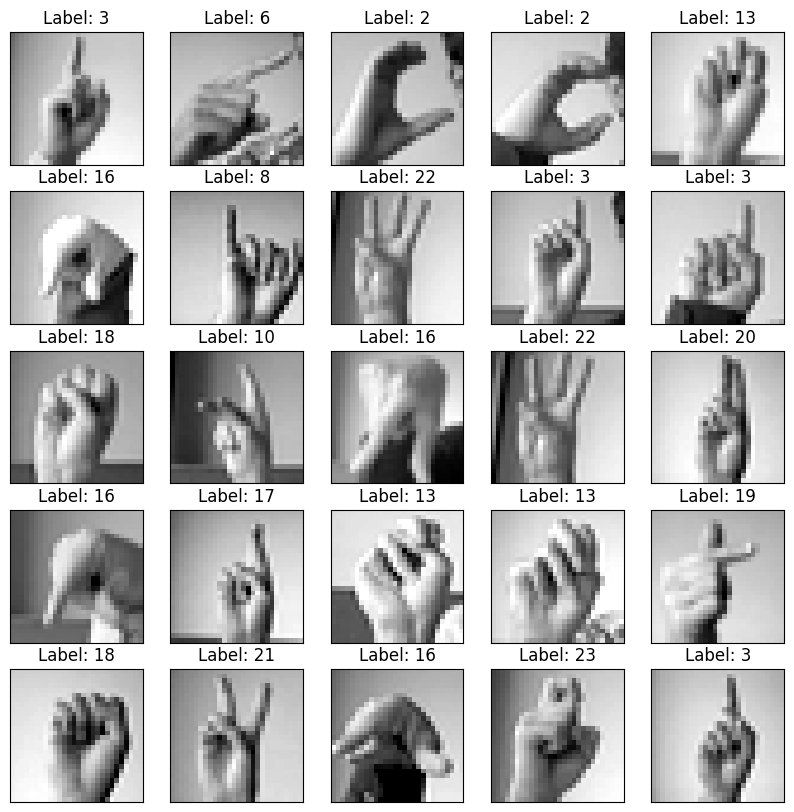

In [8]:
display_images(X_train, y_train, batch_size=25, start_index=0)

### 2 Ce dataset est-il équilibré ? Est-il nécessaire de rééquilibrer les données ? Le faire si besoin est.
Le dataset d'entraînement présente une distribution des classes relativement homogène, bien que certaines classes aient un peu plus d'exemples que d'autres. Par exemple, la classe 16 contient 1 279 exemples, tandis que la classe 4 n'en contient que 957. Néanmoins, aucune classe ne semble être dramatiquement sous-représentée au point de nécessiter un rééquilibrage des données par sur-échantillonnage ou sous-échantillonnage.

Le dataset de test présente une distribution similaire à celle de l'entraînement, mais avec des variations plus notables. Par exemple, la classe 4 possède 498 exemples, alors que la classe 17 n'en a que 144. Cependant, cela ne semble pas poser de problème significatif pour l'entraînement du modèle.

En résumé, bien que les datasets ne soient pas parfaitement équilibrés, ils ne nécessitent pas de rééquilibrage spécifique, car les écarts de distribution entre les classes ne sont pas extrêmement importants.

### Réseau de neurones convolutif

Ce modèle de réseau de neurones convolutif (CNN) prend en entrée des images de 28x28 pixels, applique des couches de convolution pour extraire des caractéristiques, les réduit avec des couches de pooling, puis passe par des couches complètement connectées pour effectuer la classification en 24 classes avec une sortie softmax pour fournir les probabilités.

In [9]:
def create_cnn_model(input_shape=(28, 28, 1), num_classes=25, optimizer='adam', dropout_rate=0.5, neurons=64):
    model = models.Sequential()

    # First convolutional layer
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Third convolutional layer
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    
    # Flatten and fully connected layers
    model.add(layers.Flatten())

    # Dense layer with customizable number of neurons and regularization (optional)
    model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=l2(0.001)))

    # Dropout layer
    model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

cnn_model = create_cnn_model()
cnn_model.summary()


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         1,625 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,297 (368.35 KB)

 Trainable params: 94,297 (368.35 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement du modèle construit à la question précédente et mesure de sa performance.

In [10]:
# Entraîner le modèle
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, 
                        validation_data=(X_test, y_test))

# Évaluer le modèle sur les données de test
test_loss, test_acc = cnn_model.evaluate(X_test, y_test)

print(f'Accuracy on test set: {test_acc:.4f}')


Epoch 1/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.1613 - loss: 2.8460 - val_accuracy: 0.6736 - val_loss: 1.1085
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6356 - loss: 1.1938 - val_accuracy: 0.8229 - val_loss: 0.7101
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7717 - loss: 0.8258 - val_accuracy: 0.8634 - val_loss: 0.5760
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8268 - loss: 0.6776 - val_accuracy: 0.8781 - val_loss: 0.6121
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8555 - loss: 0.6057 - val_accuracy: 0.8951 - val_loss: 0.5450
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8754 - loss: 0.5417 - val_accuracy: 0.9200 - val_loss: 0.5129
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8945 - loss: 0.4971 - val_accuracy: 0.9229 - val_loss: 0.4856
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9075 - loss: 0.4638 - val_accu

### Affichages des courbes d'évolution de la précision et de la perte

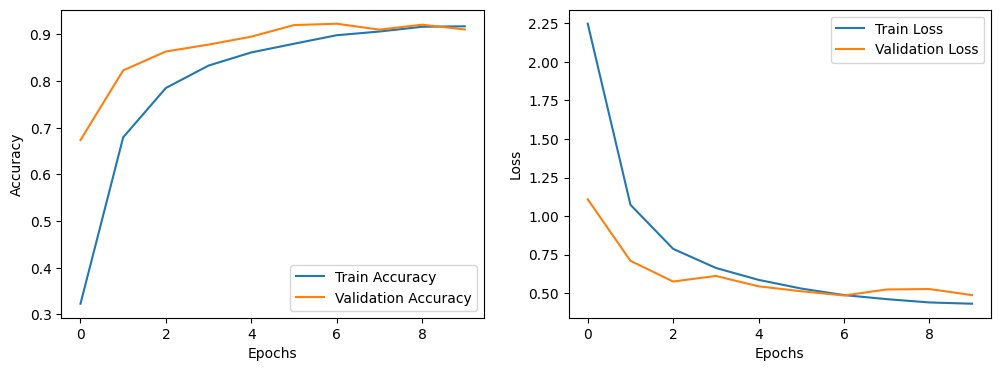

In [11]:
plt.figure(figsize=(12, 4))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Recherche d'hyper paramètre avec grid search 

In [12]:

checkpoint_dir = './checkpoints/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_filepath = os.path.join(checkpoint_dir, 'best_model.keras')

param_grid = {
    'model__neurons': [32, 64, 128],
    'epochs': [5, 10, 25, 50],
    'batch_size': [32, 64, 128],
    'dropout_rate': [0.3, 0.5, 0.7],
    'optimizer': ['adam', 'rmsprop']
}

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Sauvegarder tout le modèle (architecture + poids)
    monitor='val_accuracy',  # Surveiller l'accuracy de validation
    mode='max',  # On souhaite que l'accuracy soit maximale
    save_best_only=True,  # Sauvegarder uniquement si le modèle est meilleur
    verbose=0
)

# Définir le callback EarlyStopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=0,
    restore_best_weights=True
)

model = KerasClassifier(
    model=create_cnn_model,
    epochs=10,  # Valeur par défaut que l'on pourra modifier via GridSearch
    batch_size=32,  # Valeur par défaut que l'on pourra modifier via GridSearch
    optimizer='adam',  # Valeur par défaut
    dropout_rate=0.5,  # Valeur par défaut
    verbose=0,  # Pour éviter trop de logs durant la recherche
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

# Appliquer GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=3)

# Exécuter la recherche des meilleurs hyperparamètres
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))

# Afficher les meilleurs paramètres trouvés et leur performance
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_:.4f}")


# Évaluer les performances sur les données de test
test_loss, test_acc = grid_result.best_estimator_.model_.evaluate(X_test, y_test)
print(f'Accuracy on test set: {test_acc:.4f}')

Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer u

[CV 1/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=32, optimizer=rmsprop;, score=0.547 total time= 1.5min
[CV 1/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=32, optimizer=adam;, score=0.489 total time= 1.5min
[CV 2/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=32, optimizer=rmsprop;, score=0.556 total time= 1.5min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer u

[CV 2/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=64, optimizer=adam;, score=0.715 total time= 1.5min
[CV 2/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=32, optimizer=adam;, score=0.689 total time= 1.5min
[CV 1/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=64, optimizer=adam;, score=0.804 total time= 1.5min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 3/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=32, optimizer=rmsprop;, score=0.613 total time= 1.5min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer u

[CV 3/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=64, optimizer=adam;, score=0.734 total time= 1.6min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=64, optimizer=rmsprop;, score=0.739 total time= 1.6min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 3/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=32, optimizer=adam;, score=0.709 total time= 1.6min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=128, optimizer=adam;, score=0.861 total time= 1.5min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=128, optimizer=rmsprop;, score=0.804 total time= 1.5min
[CV 2/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=128, optimizer=rmsprop;, score=0.835 total time= 1.5min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=64, optimizer=rmsprop;, score=0.796 total time= 1.5min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/3] END batch_size=32, dropout_rate=0.3, epochs=10, model__neurons=32, optimizer=adam;, score=0.656 total time= 1.6min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 3/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=128, optimizer=adam;, score=0.847 total time= 1.6min
[CV 3/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=128, optimizer=rmsprop;, score=0.798 total time= 1.6min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 3/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=64, optimizer=rmsprop;, score=0.782 total time= 1.6min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 2/3] END batch_size=32, dropout_rate=0.3, epochs=10, model__neurons=32, optimizer=adam;, score=0.528 total time= 1.6min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/3] END batch_size=32, dropout_rate=0.3, epochs=5, model__neurons=128, optimizer=adam;, score=0.785 total time= 1.8min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/3] END batch_size=32, dropout_rate=0.3, epochs=10, model__neurons=32, optimizer=rmsprop;, score=0.748 total time= 1.4min
[CV 3/3] END batch_size=32, dropout_rate=0.3, epochs=10, model__neurons=32, optimizer=adam;, score=0.740 total time= 1.5min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 3/3] END batch_size=32, dropout_rate=0.3, epochs=10, model__neurons=32, optimizer=rmsprop;, score=0.617 total time= 1.5min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[CV 1/3] END batch_size=32, dropout_rate=0.3, epochs=10, model__neurons=64, optimizer=adam;, score=0.753 total time= 1.5min


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Test du meilleur model sauvergarder pendant le GridSearch

In [149]:

best_model = load_model(checkpoint_filepath)
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Best saved model accuracy on test set: {test_acc:.4f}')


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4227 - loss: 10.9318
Best saved model accuracy on test set: 0.4208


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3925 - loss: 6.0921
Best saved model accuracy on test set: 0.3912


### Augmentation D'image

Epoch 1/10


/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 21/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0308 - loss: 3.2239    

/Users/matteogora/.asdf/installs/python/3.11.9/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.0993 - loss: 2.9985 - val_accuracy: 0.4375 - val_loss: 1.7002
Epoch 2/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3684 - loss: 1.8855 - val_accuracy: 0.6735 - val_loss: 0.9608
Epoch 3/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5305 - loss: 1.3518 - val_accuracy: 0.7648 - val_loss: 0.7162
Epoch 4/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6127 - loss: 1.0995 - val_accuracy: 0.8307 - val_loss: 0.5318
Epoch 5/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6777 - loss: 0.9135 - val_accuracy: 0.8504 - val_loss: 0.4189
Epoch 6/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7104 - loss: 0.8186 - val_accuracy: 0.8721 - val_loss: 0.3807
Epoch 7/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7461 - loss: 0.7241 - val_accuracy: 0.8938 - val_loss: 0.3377
Epoch 8/10
858/858 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7643 - loss: 0.6532 - val_accuracy: 0.9308 - val_

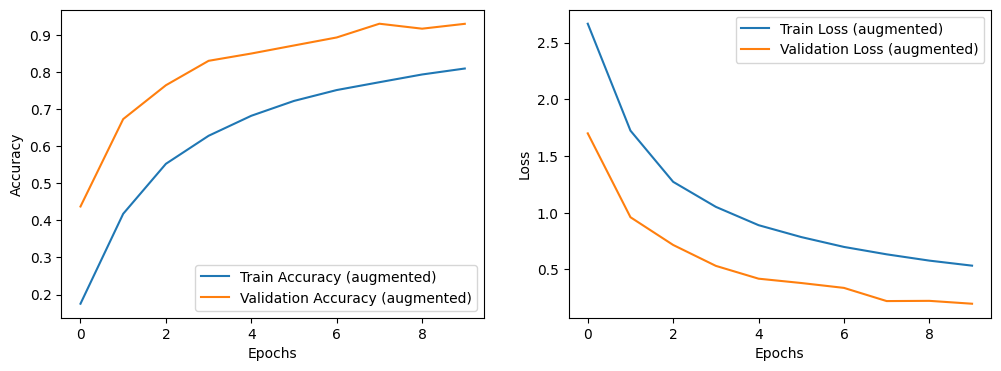

In [141]:
datagen = ImageDataGenerator(
    rotation_range=10,      # Rotation aléatoire des images
    width_shift_range=0.1,  # Décalage horizontal
    height_shift_range=0.1, # Décalage vertical
    zoom_range=0.1,         # Zoom
    horizontal_flip=True,   # Retournement horizontal
    fill_mode='nearest'     # Remplissage des pixels manquants
)

datagen.fit(X_train)

# Définir le modèle CNN (déjà fait)
cnn_model = create_cnn_model()

# Entraîner le modèle avec les données augmentées
history_augmented = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)

# Évaluer le modèle sur les données de test
test_loss_augmented, test_acc_augmented = cnn_model.evaluate(X_test, y_test)

print(f'Accuracy on test set with augmentation: {test_acc_augmented:.4f}')

# Tracer les courbes de performance (avec augmentation)
plt.figure(figsize=(12, 4))

# Courbe de précision
plt.subplot(1, 2, 1)
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy (augmented)')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy (augmented)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Courbe de perte
plt.subplot(1, 2, 2)
plt.plot(history_augmented.history['loss'], label='Train Loss (augmented)')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss (augmented)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

En Utilisant les mêmes paramètres avec l'augmentation des images on obtient des améliorations, ces améliorations étaient prévisible car cette technique est souvent recommandé quand on travail avec des datasets limités. Étant donné que les modèles de réseaux de neurones convolutifs (CNN) peuvent avoir une capacité de mémorisation élevée, exposer le modèle à une plus grande variété d'images rend les représentations apprises plus généralisées et robustes.

### Sauvegarde du meilleur model
 

In [142]:
# Sauvegarder le modèle entraîné avec les meilleurs paramètres
best_model = grid_result.best_estimator_.model_

# Créer un dossier de sauvegarde s'il n'existe pas
save_dir = './saved_models/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Sauvegarder le modèle
model_path = os.path.join(save_dir, 'best_cnn_model.h5')
best_model.save(model_path)
print(f'Model saved to {model_path}')

# Évaluer le modèle sur les données de test
test_loss_augmented, test_acc_augmented = best_model.evaluate(X_test, y_test)
print(f'Accuracy on test set with best model: {test_acc_augmented:.4f}')

Model saved to ./saved_models/best_cnn_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3925 - loss: 6.0921
Accuracy on test set with best model: 0.3912


### Nos photos et notre meilleur model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


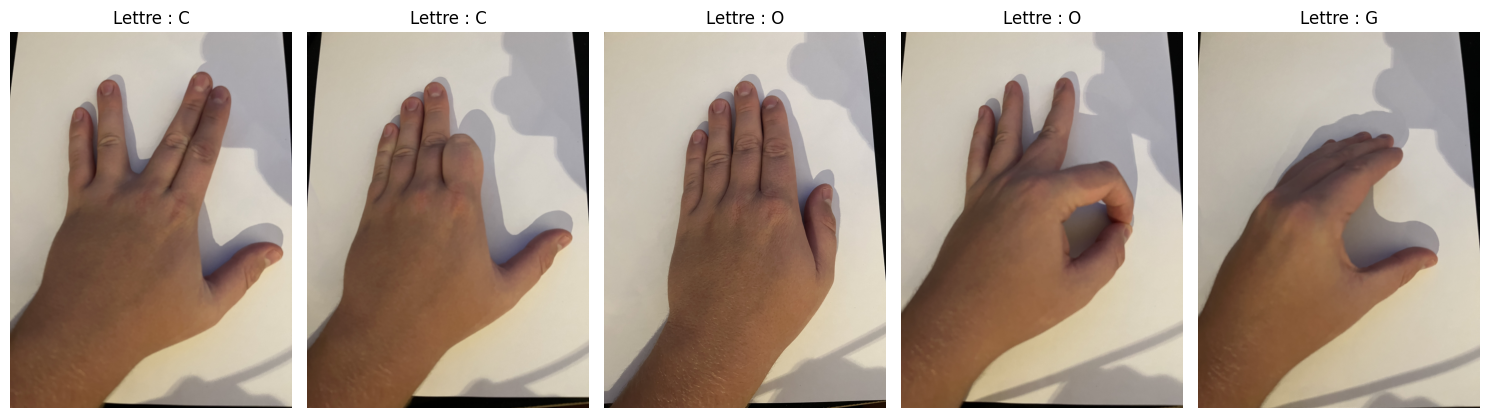

In [148]:
# Charger le meilleur modèle sauvegardé
#best_model = load_model('./saved_models/best_cnn_model.h5')
best_model = load_model('./checkpoints/best_model.keras')
# Fonction pour prétraiter les images (redimensionner, convertir en niveaux de gris, etc.)
def preprocess_image(image_path):
    # Charger l'image en niveaux de gris
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Vérifier si l'image a été correctement chargée
    if img is None:
        raise FileNotFoundError(f"Image non trouvée au chemin: {image_path}")
    
    # Redimensionner l'image à la taille 28x28 (ou la taille utilisée pour l'entraînement)
    img = cv2.resize(img, (28, 28))
    
    # Normaliser les pixels (valeurs entre 0 et 1)
    img = img.astype('float32') / 255.0
    
    # Ajouter une dimension pour correspondre au format attendu par le modèle (1, 28, 28, 1)
    img = np.expand_dims(img, axis=0)  # Ajouter la dimension du batch
    img = np.expand_dims(img, axis=-1)  # Ajouter la dimension du canal (niveaux de gris)
    
    return img

# Fonction pour prédire la lettre en langue des signes à partir d'une image
def predict_sign(image_path):
    # Prétraiter l'image
    processed_img = preprocess_image(image_path)
    
    # Faire une prédiction avec le modèle
    prediction = best_model.predict(processed_img)
    
    # Trouver l'indice de la classe prédite (qui correspond à une lettre)
    predicted_class = np.argmax(prediction, axis=1)
    
    return predicted_class

# Mapping des classes aux lettres de l'alphabet en langue des signes
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 
           'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']

# Fonction pour afficher toutes les images et leurs prédictions sur une grille
def display_images_in_grid(directory, images_per_row=5):
    # Lister toutes les images dans le répertoire
    image_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpeg') or f.endswith('.jpg')]
    
    # Nombre total d'images
    total_images = len(image_paths)
    
    # Calculer le nombre de lignes pour la grille
    rows = total_images // images_per_row + int(total_images % images_per_row != 0)
    
    # Initialiser la figure
    fig, axes = plt.subplots(rows, images_per_row, figsize=(15, 15))
    axes = axes.flatten()  # Pour manipuler chaque subplot individuellement
    
    # Boucler sur chaque image et afficher avec la prédiction
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB pour l'affichage
        
        # Prédire la classe de l'image
        predicted_class = predict_sign(image_path)
        predicted_letter = classes[predicted_class[0]]
        
        # Afficher l'image avec la prédiction
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"Lettre : {predicted_letter}")
        axes[i].axis('off')  # Enlever les axes pour une meilleure visibilité
    
    # Enlever les axes vides (pour les sous-grilles non utilisées)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Spécifier le répertoire contenant les images
image_directory = './my_hand/'

# Afficher toutes les images et les prédictions sur une grille
display_images_in_grid(image_directory)



### Comparaison entre notre model et un model pré-entrainés disponible avec keras